## VAE digits

In [1]:
import torch.nn as nn

In [2]:
import numpy as np
import json
import os
import pickle

In [3]:
import torch
import torch.optim as optim

In [4]:
import collections

In [5]:
from torchsummary import summary as torch_network_summary

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm

In [7]:
from tqdm import tqdm_notebook as tqdm

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class Encoder_part(nn.Module):
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        , use_VAE = False
        ):
        super(Encoder_part, self).__init__()

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.input_filter = self.input_dim[0]
        self.encoder_conv_filters_input = [self.input_filter] + encoder_conv_filters[:-1]
        self.encoder_conv_filters_output = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.z_dim = z_dim
        
        self.use_VAE = use_VAE

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        
        self.conv_layers = nn.Sequential()
        self.output_shape = collections.OrderedDict()
        
        self.output_shape['Input'] = self.input_dim
        current_layer_name = 'Input'
        current_input_shape = self.output_shape[current_layer_name]
        
        for i in range(self.n_layers_encoder):
            
            current_filter, input_H, input_W = current_input_shape
            current_layer_name = 'Layer {} Conv2d'.format(i)
            
            kernel = self.encoder_conv_kernel_size[i]
            stride = self.encoder_conv_strides[i]
            
            _output_H = int((input_H-kernel)/stride) + 1
            _output_W = int((input_W-kernel)/stride) + 1
            
            if int(input_H/stride) != _output_H:
                padding = max(0, int((kernel-(_output_H%stride))/2))
            else:
                padding = 0
            
            output_H = int((input_H-kernel+2*padding)/stride) + 1
            output_W = int((input_W-kernel+2*padding)/stride) + 1
            
            self.output_shape[current_layer_name] = [self.encoder_conv_filters_output[i], output_H, output_W]
            current_input_shape = self.output_shape[current_layer_name]
            
            self.conv_layers.add_module(current_layer_name,
                            nn.Conv2d(self.encoder_conv_filters_input[i]
                                    , self.encoder_conv_filters_output[i]
                                    , kernel_size = self.encoder_conv_kernel_size[i]
                                    , stride = self.encoder_conv_strides[i]
                                    , padding = padding
                                    ))
            if self.use_batch_norm:
                
                self.conv_layers.add_module('Layer {} BatchNorm2d'.format(i), 
                                            nn.BatchNorm2d(self.encoder_conv_filters_output[i]))

            self.conv_layers.add_module('Layer {} LeakyReLU'.format(i), nn.LeakyReLU())

            if self.use_dropout:
                self.conv_layers.add_module('Layer {} Dropout2d'.format(i), nn.Dropout2d(p=0.25))
        
        self.encoder_cnn_output_shape = current_input_shape
        self.Flattened_shape = np.prod(self.encoder_cnn_output_shape)
        
        
        if self.use_VAE:
            self.mu = nn.Linear(self.Flattened_shape, self.z_dim)
            self.log_var = nn.Linear(self.Flattened_shape, self.z_dim)
            self.kl_loss = None
        else:
            self.Flattened = nn.Linear(self.Flattened_shape, self.z_dim)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size()[0],-1)
        
        if self.use_VAE:
            epsilon = torch.randn(self.z_dim).to(device)
            self.epsilon = epsilon
            mu = self.mu(x)
            log_var = self.log_var(x)
            encoder_output = mu + torch.exp(log_var/2) * epsilon
            
        else:
            encoder_output = self.Flattened(x)
            mu = None
            log_var = None
            
        return encoder_output, mu, log_var
        

In [10]:
class Decoder_part(nn.Module):
    def __init__(self
        , encoder_cnn_output_shape
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):
        super(Decoder_part, self).__init__()
    
        self.encoder_cnn_output_shape = encoder_cnn_output_shape
        self.decoder_conv_t_filters_input = [encoder_cnn_output_shape[0]] + decoder_conv_t_filters[:-1]
        self.decoder_conv_t_filters_output = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_decoder = len(decoder_conv_t_filters)
        
        
        self.conv_layers = nn.Sequential()
        self.output_shape = collections.OrderedDict()
        
        self.output_shape['Input'] = self.encoder_cnn_output_shape
        current_layer_name = 'Input'
        current_input_shape = self.output_shape[current_layer_name]
        
        self.Reshaping = nn.Linear(self.z_dim, np.prod(self.encoder_cnn_output_shape))
        
        for i in range(self.n_layers_decoder):
            
            current_filter, input_H, input_W = current_input_shape
            current_layer_name = 'Layer {} Conv2d'.format(i)
            
            kernel = self.decoder_conv_t_kernel_size[i]
            stride = self.decoder_conv_t_strides[i]
            
            _output_H = (input_H-1)*stride + kernel
            _output_W = (input_W-1)*stride + kernel
            
            if int(input_H*stride) != _output_H:
                padding = (_output_H-input_H*stride)/2
                if padding%1 == 0.5:
                    padding = max(0, int(padding)) + 1
                    output_padding = 1
                else:
                    padding = int(padding)
                    output_padding = 0
            else:
                padding = 0
                output_padding = 0
            
            output_H = (input_H-1)*stride + kernel - 2*padding + output_padding
            output_W = (input_W-1)*stride + kernel - 2*padding + output_padding
            
            self.output_shape[current_layer_name] = [self.decoder_conv_t_filters_output[i], output_H, output_W]
            current_input_shape = self.output_shape[current_layer_name]
            
            self.conv_layers.add_module(current_layer_name,
                            nn.ConvTranspose2d(self.decoder_conv_t_filters_input[i]
                                    , self.decoder_conv_t_filters_output[i]
                                    , kernel_size = self.decoder_conv_t_kernel_size[i]
                                    , stride = self.decoder_conv_t_strides[i]
                                    , padding = padding
                                    , output_padding = output_padding
                                    ))
            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    self.conv_layers.add_module('Layer {} BatchNorm2d'.format(i), 
                                                nn.BatchNorm2d(self.decoder_conv_t_filters_output[i]))

                self.conv_layers.add_module('Layer {} LeakyReLU'.format(i), nn.LeakyReLU())

                if self.use_dropout:
                    self.conv_layers.add_module('Layer {} Dropout2d'.format(i), nn.Dropout2d(p=0.25))
            else:
                self.conv_layers.add_module('Layer {} Sigmoid'.format(i), nn.Sigmoid())
        
    def forward(self, x):
        x = self.Reshaping(x)
        x = x.reshape([x.size()[0]]+self.encoder_cnn_output_shape)
        x = self.conv_layers(x)
        
        return x

In [11]:
class Autoenocoder_pt(nn.Module):
    def __init__(self,
                encoder, decoder):
        super(Autoenocoder_pt, self).__init__()
        self.encoder_part = encoder_part
        self.decoder_part = decoder_part
        
    def forward(self, x):
        x, _, _ = self.encoder_part(x)
        x = self.decoder_part(x)
        
        return x

## Training

In [12]:
channels, H, W = 1, 28, 28

In [13]:
sample_input = torch.rand(1,channels, H, W).to(device)
input_dim = sample_input.cpu().numpy().shape[1:]

In [14]:
encoder_conv_filters = [32,64,64, 64]
encoder_conv_kernel_size = [3,3,3,3]
encoder_conv_strides = [1,2,2,1]
decoder_conv_t_filters = [64,64,32,1]
decoder_conv_t_kernel_size = [3,3,3,3]
decoder_conv_t_strides = [1,2,2,1]
z_dim = 2

In [15]:
use_VAE_mode = True

In [16]:
encoder_part = Encoder_part(
            input_dim = input_dim
        , encoder_conv_filters = encoder_conv_filters
        , encoder_conv_kernel_size = encoder_conv_kernel_size
        , encoder_conv_strides = encoder_conv_strides
        , z_dim = z_dim
#         , use_batch_norm = True
#         , use_dropout= True
        , use_VAE = use_VAE_mode
).to(device)

In [17]:
decoder_part = Decoder_part(
        encoder_cnn_output_shape = encoder_part.encoder_cnn_output_shape
        , decoder_conv_t_filters = decoder_conv_t_filters
        , decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        , decoder_conv_t_strides = decoder_conv_t_strides
        , z_dim = z_dim
#         , use_batch_norm = True
#         , use_dropout= True
).to(device)

In [18]:
AE = Autoenocoder_pt(encoder_part, decoder_part)

torch_network_summary(AE, encoder_part.input_dim)

In [ ]:
from utils.loaders import load_mnist, load_model
from torch.utils.data import DataLoader

Using TensorFlow backend.


In [ ]:
(_x_train, y_train), (_x_test, y_test) = load_mnist()
_x_train_t = np.transpose(_x_train, (0,3,1,2))
_x_test_t = np.transpose(_x_test, (0,3,1,2))

x_train = torch.from_numpy(_x_train_t).to(device)
x_test = torch.from_numpy(_x_test_t).to(device)

input_data = [[x_item, y_item] for x_item, y_item in zip(_x_train_t, y_train)]

In [ ]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000 # 뒤에 mu log_var만 학습됨
R_LOSS_FACTOR = 10000 # autoencoder부분만 학습됨
R_LOSS_FACTOR = 5000 # autoencoder부분만 학습됨
R_LOSS_FACTOR = 2000 # autoencoder부분만 학습됨

In [ ]:
optimizer = optim.Adam(AE.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss().to(device)

In [ ]:
import pandas as pd

In [ ]:
batch_count = 0

In [ ]:
loss_df = pd.DataFrame(columns = ['loss', 'r_loss', 'kl_loss'])

batch_loss = pd.DataFrame([[1,2,3]], columns = ['loss', 'r_loss', 'kl_loss'])
batch_loss.index = [batch_count]
loss_df = loss_df.append(batch_loss)

로직은 epoch 1부터는 많이 안줄어든 쪽에 더 가중치를 줘서 학습시키는 것이다.

그럴라면, moving average의 감소가 큰 쪽에는 적은 weight를 주고, 감소가 작은 쪽에는 큰 weight를 줘야겠으며,

또 감소속도 자체의 속도도 서로 같도록 만들어줘야지.

그래서 loss가 서로 비슷한 scale을 갖도록 조정해주고,

또 loss의 크기 자체도 맞추고 싶은데, 어떻게 하냐면, 무빙에버리지의 역수를 곱해주자.

그렇게 만들어진 loss를 줄이는 방향으로. 그래서 epoch 0는 일종의 sampling 기간으로 삼고, 그 다음부터는 이 weight에 따라서 매 배치마다 fine tuning을 계속해나가는 식으로 가자.

아 아니면, 봐봐, 이게 1000일때는 뮤 시그마만 학습하고, 그보다 클때는 또 ae만 학습하잖아.

그러면, 우선 epoch 0에서는 5000 잡고, epoch 1에서는 100 정도 잡고

그 다음 epoch 2에서 batch sampling해서 학습해보자.

In [ ]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000 # 뒤에 mu log_var만 학습됨
R_LOSS_FACTOR = 10000 # autoencoder부분만 학습됨
R_LOSS_FACTOR = 5000 # autoencoder부분만 학습됨
R_LOSS_FACTOR = 2000 # autoencoder부분만 학습됨
KL_LOSS_FACTOR = 1 # autoencoder부분만 학습됨

In [ ]:
loss_summary_df = loss_df.iloc[256:].mean()

r_loss = loss_summary_df['r_loss']
kl_loss = loss_summary_df['kl_loss']

In [ ]:
try:
    loss_df_mov = loss_df.rolling(window=512).mean().dropna().copy(deep=True)

    loss_df_mov_t0 = loss_df_mov.iloc[0]
    loss_df_mov_t1 = loss_df_mov.iloc[-1]

    r_loss_t0 = loss_df_mov_t0['r_loss']
    r_loss_t1 = loss_df_mov_t1['r_loss']

    kl_loss_t0 = loss_df_mov_t0['kl_loss']
    kl_loss_t1 = loss_df_mov_t1['kl_loss']
    
    kl_loss_weight = max(0, 1/((r_loss_t1-r_loss_t0)/r_loss_t0))
    r_loss_weight = max(0, 1/((kl_loss_t1-kl_loss_t0)/kl_loss_t0))
except:
    pass

많이 감소했을 수록, 낮은 weight가 들어간다.

그러면 만약 loss가 증가했다면? 이 경우는 위의 메져에서 max의 뒤쪽에 들어가는 친구가 -의 값을 가질거라고. 그러면 max(0, ~)이니까 걔는 0이 될 것이고, 이 말은 즉슨, 학습을 아예 하지 못하는 부분의 경우 weight가 0으로 들어가버린다는 얘기야.

그러니까, 매우 천천히 감소하는 경우 말고, 아예 감소를 못하고 있다면, 걔는 weight가 0으로 들어가버리는 것이지.

In [ ]:
EPOCHS = 200

AE.train()

best_loss = 0
early_stopping_count = 0
total_loss_list = []
total_r_loss_list = []
total_kl_loss_list = []

batch_count = 0
loss_df = pd.DataFrame(columns = ['loss', 'r_loss', 'kl_loss'])

ADDITIONAL_LOSS = False

r_loss_weight = 1
kl_loss_weight = 1

R_LOSS_FACTOR = 1000
    
for epoch in range(EPOCHS):
    total_loss = 0
    total_r_loss = 0
    total_kl_loss = 0
    
    for x_batch, y_batch in tqdm(DataLoader(input_data, 32, True)):
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
#         decoder_output = AE(x_batch)
        encoder_output, mu, log_var = AE.encoder_part(x_batch)
        decoder_output = AE.decoder_part(encoder_output)
        
#         r_loss = criterion(x_batch, decoder_output)
        r_loss = ((decoder_output - x_batch)**2).mean(dim=[1,2,3])
        total_r_loss += r_loss.mean().item()
        if AE.encoder_part.use_VAE:
            
            kl_loss =  torch.sum(-0.5 * (1 + log_var - mu**2 - torch.exp(log_var)), dim=[1])
            
            loss = R_LOSS_FACTOR * r_loss + KL_LOSS_FACTOR * kl_loss
            
            total_kl_loss += kl_loss.mean().item()
        else:
            loss = r_loss
        
        total_loss += loss.mean().item()
        
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    
    if epoch == 0:
        best_loss = total_loss
    else:
        if total_loss < best_loss:
            best_loss = total_loss
            early_stopping_count += 1
    total_loss_list.append(total_loss)
    total_r_loss_list.append(total_r_loss)
    
    if AE.encoder_part.use_VAE:
        total_kl_loss_list.append(total_kl_loss)
        
        info2print = '{}  {}  {}  {}'.format(epoch, total_loss, total_r_loss, total_kl_loss)
    else:
        info2print = '{}  {}  {}'.format(epoch, total_loss, total_r_loss)
    
    print(info2print)
    if early_stopping_count>=100:
        break

/home/hojun/.virtualenvs/gan/lib/python3.6/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0  107249.95905303955  101.3408646658063  5909.0942954281345



1  93783.4105758667  85.76606239378452  8017.348087072372



2  90410.34806442261  81.65355819091201  8756.789991140366



3  88564.97529220581  79.48449137434363  9080.483920574188



4  87195.12621688843  77.92580747231841  9269.31870174408



5  86357.4377784729  76.92950999177992  9427.927795886993



6  85685.81772613525  76.08655383810401  9599.26390838623



7  85041.10079956055  75.33417905680835  9706.921744823456



8  84529.57697677612  74.74390658922493  9785.670324802399



9  84035.03930282593  74.22204599902034  9812.99324131012



10  83633.72079086304  73.77729193493724  9856.428877353668



11  83317.10475158691  73.32968573272228  9987.419005393982



12  83057.05945587158  73.00346008501947  10053.599297046661



13  82722.1630859375  72.63260198570788  10089.561212062836



14  82459.15607452393  72.30398788675666  10155.168019771576



15  82288.65227890015  72.10949834249914  10179.153958320618



16  82038.74234008789  71.8154469281435  10223.295385360718



17  81807.93982696533  71.54152638837695  10266.413462638855



18  81607.29278564453  71.34866218827665  10258.630718231201



19  81488.57363128662  71.17288355715573  10315.690170288086



20  81183.38918685913  70.91062577068806  10272.763273715973



21  81173.81390762329  70.79098391719162  10382.830236911774



22  81083.9870300293  70.65612759254873  10427.859513282776



23  80832.44696807861  70.45648402348161  10375.963140010834



24  80792.12817764282  70.29253369942307  10499.594309329987



25  80612.33283233643  70.08824660629034  10524.086187839508



26  80469.95164871216  70.02401529066265  10445.936433792114



27  80281.4186668396  69.86621121875942  10415.207404613495



28  80289.12466430664  69.72847301326692  10560.65170431137


In [29]:
EPOCHS = 100

AE.train()

best_loss = 0
early_stopping_count = 0
total_loss_list = []
total_r_loss_list = []
total_kl_loss_list = []

batch_count = 0
loss_df = pd.DataFrame(columns = ['loss', 'r_loss', 'kl_loss'])

ADDITIONAL_LOSS = False

r_loss_weight = 1
kl_loss_weight = 1

for epoch in range(EPOCHS):
    total_loss = 0
    total_r_loss = 0
    total_kl_loss = 0

    
    if epoch == 0:
        R_LOSS_FACTOR = 5000
        KL_LOSS_FACTOR = 1
    elif epoch == 1:
        R_LOSS_FACTOR = 100
        KL_LOSS_FACTOR = 1
    elif epoch == 2:
        R_LOSS_FACTOR = 1000
        KL_LOSS_FACTOR = 1
    else:
        loss_summary_df = loss_df.iloc[256:].mean()

        r_loss = loss_summary_df['r_loss']
        kl_loss = loss_summary_df['kl_loss']
        
        R_LOSS_FACTOR = 1/r_loss
        KL_LOSS_FACTOR = 1/kl_loss
    
    for x_batch, y_batch in tqdm(DataLoader(input_data, 32, True)):
        
        if loss_df.shape[0]>=2048:
            
            ADDITIONAL_LOSS = True
            
            loss_summary_df = loss_df.mean()

            r_loss = loss_summary_df['r_loss']
            kl_loss = loss_summary_df['kl_loss']

            # loss가 큰 곳에 더 큰 비중을 둬서 줄여나가야지.
            R_LOSS_FACTOR = r_loss
            KL_LOSS_FACTOR = kl_loss
            
            loss_df_mov = loss_df.rolling(window=1024).mean().dropna().copy(deep=True)

            prev_loss_df_mov_t0 = loss_df_mov.iloc[0]
            prev_loss_df_mov_t1 = loss_df_mov.iloc[512]
            
            loss_df_mov_t0 = loss_df_mov.iloc[-512]
            loss_df_mov_t1 = loss_df_mov.iloc[-1]

            prev_r_loss_t0 = prev_loss_df_mov_t0['r_loss']
            prev_r_loss_t1 = prev_loss_df_mov_t1['r_loss']

            prev_kl_loss_t0 = prev_loss_df_mov_t0['kl_loss']
            prev_kl_loss_t1 = prev_loss_df_mov_t1['kl_loss']
            
            r_loss_t0 = loss_df_mov_t0['r_loss']
            r_loss_t1 = loss_df_mov_t1['r_loss']

            kl_loss_t0 = loss_df_mov_t0['kl_loss']
            kl_loss_t1 = loss_df_mov_t1['kl_loss']
            
            prev_r_loss_dec_speed = ((-prev_r_loss_t1+prev_r_loss_t0)/prev_r_loss_t0)
            prev_kl_loss_dec_speed = ((-prev_kl_loss_t1+prev_kl_loss_t0)/prev_kl_loss_t0)
            
            r_loss_dec_speed = ((-r_loss_t1+r_loss_t0)/r_loss_t0)
            kl_loss_dec_speed = ((-kl_loss_t1+kl_loss_t0)/kl_loss_t0)
            
            # 감소속도의 차이를 보자.
            # 만약에 감소하지 못한 loss가 있다면 거기에 1의 weihgt를 상대방에게 0의 weight를 준다.
            if r_loss_dec_speed<0 and kl_loss_dec_speed>=0:
                r_loss_weight = 1
                kl_loss_weight = 0
            elif r_loss_dec_speed>=0 and kl_loss_dec_speed<0:
                r_loss_weight = 0
                kl_loss_weight = 1
            elif r_loss_dec_speed<0 and kl_loss_dec_speed<0:
                r_loss_weight = 0.5
                kl_loss_weight = 0.5
            else:
                # 빨리 줄어든 것에 적은 weight를 줘야지
                denominator = (r_loss_dec_speed) + (kl_loss_dec_speed)
                r_loss_weight = kl_loss_dec_speed/denominator
                kl_loss_weight = r_loss_dec_speed/denominator
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
#         decoder_output = AE(x_batch)
        encoder_output, mu, log_var = AE.encoder_part(x_batch)
        decoder_output = AE.decoder_part(encoder_output)
        
#         r_loss = criterion(x_batch, decoder_output)
        r_loss = ((decoder_output - x_batch)**2).mean(dim=[1,2,3])
        total_r_loss += r_loss.mean().item()
        if AE.encoder_part.use_VAE:
            
            kl_loss =  torch.sum(-0.5 * (1 + log_var - mu**2 - torch.exp(log_var)), dim=[1])
            
            if ADDITIONAL_LOSS:
            
                loss = R_LOSS_FACTOR * r_loss_weight * r_loss + KL_LOSS_FACTOR * kl_loss_weight * kl_loss
                
            else:
                
                loss = R_LOSS_FACTOR * r_loss + KL_LOSS_FACTOR * kl_loss
            
            total_kl_loss += kl_loss.mean().item()
        else:
            loss = r_loss
        
        total_loss += loss.mean().item()
        
        if epoch>=2:
            batch_loss = pd.DataFrame([[loss.mean().item(),r_loss.mean().item(),kl_loss.mean().item()]], columns = ['loss', 'r_loss', 'kl_loss'])
            batch_loss.index = [batch_count]
            loss_df = loss_df.append(batch_loss)
            batch_count+=1
            
            if loss_df.shape[0]>=2048:
                loss_df = loss_df[-2048:].copy(deep=True)
        
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    
    if epoch == 0:
        best_loss = total_loss
    else:
        if total_loss < best_loss:
            best_loss = total_loss
            early_stopping_count += 1
    total_loss_list.append(total_loss)
    total_r_loss_list.append(total_r_loss)
    
    if AE.encoder_part.use_VAE:
        total_kl_loss_list.append(total_kl_loss)
        
        info2print = '{}  {}  {}  {}'.format(epoch, total_loss, total_r_loss, total_kl_loss)
    else:
        info2print = '{}  {}  {}'.format(epoch, total_loss, total_r_loss)
    
    print(info2print)
    if early_stopping_count>=20:
        break

/home/hojun/.virtualenvs/gan/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0  491054.7921447754  96.08604264631867  10624.578951652162



1  13216.38259267807  113.99370021000504  1817.0125877857208



2  92710.01206588745  84.22023956850171  8489.77280241251



3  323.05008867464494  117.35380160063505  2560.8573751188815



4  11.16469612452056  156.01359048858285  359.6187380878255



5  9.413019012342374  154.3535180464387  6.581705112941563



6  3.4145703077758753  149.07577770203352  10.58536367956549



7  4.518767349936184  143.35682789236307  14.448993930593133



8  4.0305853539503005  135.59518295526505  9.552590053528547



9  5.955138167770713  129.4418492242694  15.57135515846312



10  4.108587665408436  127.46811802312732  6.781218931078911



11  4.989750569717387  126.64856262505054  12.63351826928556


KeyboardInterrupt: 

## Model Save

In [ ]:
torch.save(AE.state_dict(), './models_saved/vae-20200209-v02.pt')

In [ ]:
channels, H, W = 1, 28, 28

sample_input = torch.rand(1,channels, H, W).to(device)
input_dim = sample_input.cpu().numpy().shape[1:]

encoder_conv_filters = [32,64,64, 64]
encoder_conv_kernel_size = [3,3,3,3]
encoder_conv_strides = [1,2,2,1]
decoder_conv_t_filters = [64,64,32,1]
decoder_conv_t_kernel_size = [3,3,3,3]
decoder_conv_t_strides = [1,2,2,1]
z_dim = 2

use_VAE_mode = True

encoder_part = Encoder_part(
            input_dim = input_dim
        , encoder_conv_filters = encoder_conv_filters
        , encoder_conv_kernel_size = encoder_conv_kernel_size
        , encoder_conv_strides = encoder_conv_strides
        , z_dim = z_dim
#         , use_batch_norm = True
#         , use_dropout= True
        , use_VAE = use_VAE_mode
).to(device)

decoder_part = Decoder_part(
        encoder_cnn_output_shape = encoder_part.encoder_cnn_output_shape
        , decoder_conv_t_filters = decoder_conv_t_filters
        , decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        , decoder_conv_t_strides = decoder_conv_t_strides
        , z_dim = z_dim
#         , use_batch_norm = True
#         , use_dropout= True
).to(device)

In [ ]:
model = Autoenocoder_pt(encoder_part, decoder_part)

In [ ]:
model.load_state_dict(torch.load('./models_saved/vae-20200209-v02.pt'))
model.eval()

## Analysis

In [ ]:
(_x_train, y_train), (_x_test, y_test) = load_mnist()
_x_train_t = np.transpose(_x_train, (0,3,1,2))
_x_test_t = np.transpose(_x_test, (0,3,1,2))

x_train = torch.from_numpy(_x_train_t).to(device)
x_test = torch.from_numpy(_x_test_t).to(device)

In [ ]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
_example_images = x_test[example_idx]

example_images = _example_images.cpu().numpy()

In [ ]:
_z_points, _, _ = model.encoder_part(_example_images)
z_points = _z_points.cpu().detach().numpy()

_reconst_images = model.decoder_part(_z_points)
reconst_images = _reconst_images.cpu().detach().numpy()

## Variational AutoEncoder 결과

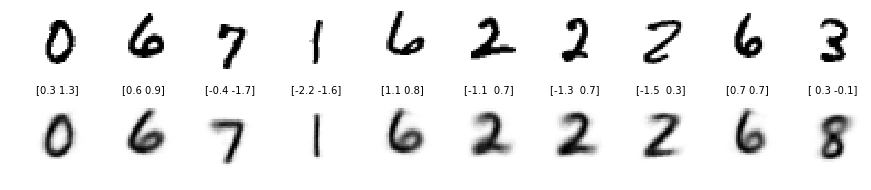

In [37]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

## Epoch 200짜리

In [ ]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

## Mr N. Coder's wall

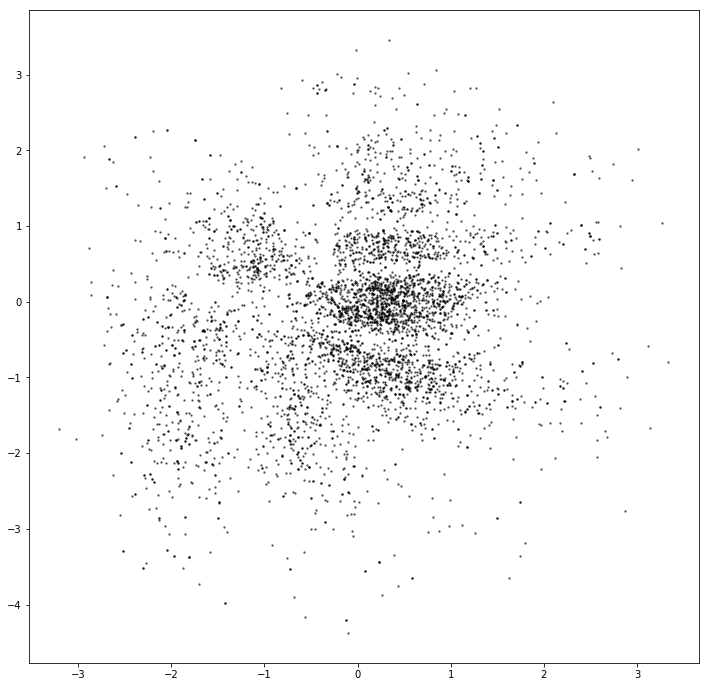

In [38]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
_example_images = x_test[example_idx]

example_images = _example_images.cpu().numpy()
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

_z_points, _, _ = model.encoder_part(_example_images)
z_points = _z_points.cpu().detach().numpy()

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

### The new generated art exhibition

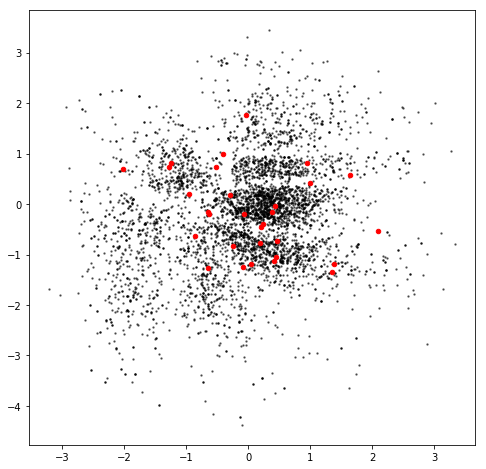

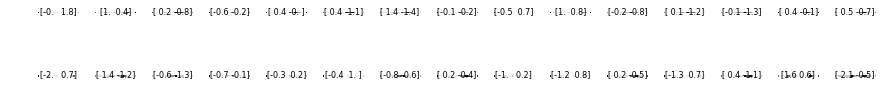

In [55]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

_z_grid = np.array(list(zip(x, y)))
z_grid = torch.from_numpy(_z_grid).to(device)
reconst = model.decoder_part(z_grid.float()).cpu().detach().numpy()
z_grid = z_grid.cpu().detach().numpy()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

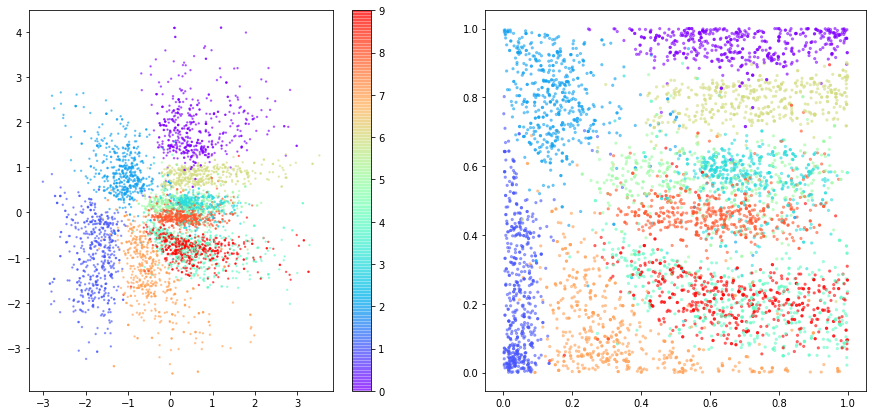

In [56]:
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
_example_images = x_test[example_idx]
example_images = _example_images.cpu().numpy()
example_labels = y_test[example_idx]

_z_points, _, _ = model.encoder_part(_example_images)
z_points = _z_points.cpu().detach().numpy()
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)

plt.show()

n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
_example_images = x_test[example_idx]
example_images = _example_images.cpu().numpy()
example_labels = y_test[example_idx]

_z_points, _, _ = model.encoder_part(_example_images)
z_points = _z_points.cpu().detach().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
_z_grid = np.array(list(zip(xv, yv)))

z_grid = torch.from_numpy(_z_grid).to(device)
reconst = model.decoder_part(z_grid.float()).cpu().detach().numpy()

z_grid = z_grid.cpu().detach().numpy()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')